The intuition behind a **Decision Tree** is to make decisions by asking a series of simple "if/else" questions about the features, splitting the data into progressively purer subsets. Its key parameters, like `max_depth` and `min_samples_leaf`, are used to control the tree's complexity and prevent it from overfitting to the training data.

---
## 1. The Intuition Behind Decision Trees 🌳

Think of a decision tree like playing a game of "20 Questions." You start with a diverse group of data points and your goal is to separate them into distinct classes by asking a sequence of simple questions.

Imagine you want to decide whether to play tennis. You might ask:
1.  **Is the outlook sunny, overcast, or rainy?**
    * If it's rainy, you decide **not to play**.
    * If it's sunny, you ask a follow-up question.
2.  **Is the humidity high?**
    * If it's high, you decide **not to play**.
    * If it's normal, you **play**.
3.  If the outlook was overcast, you always decide to **play**.

This is exactly how a decision tree works. It learns a hierarchy of questions (called **splits**) about the features that are most effective at separating the data.

* **Root Node**: The starting point that contains all the data.
* **Decision Nodes**: Nodes where a question is asked and the data is split.
* **Leaf Nodes**: The final nodes that contain the classification or prediction (e.g., "Play" or "Don't Play").

The algorithm's main job is to find the best question (feature and split point) at each step—the one that creates the "purest" possible child nodes, where each node contains data from a single class as much as possible.



---
## 2. Key Parameters for Decision Tree Classifiers

These parameters are crucial for controlling the tree's growth and preventing **overfitting**, where the model learns the training data too well and fails to generalize to new data. These are the common parameter names found in libraries like Scikit-learn.

#### `criterion`
This parameter determines the function used to measure the quality of a split. The goal is to choose a split that makes the resulting nodes as "pure" as possible.
* **`'gini'` (Gini Impurity)**: Measures the probability of misclassifying a randomly chosen element. It's the default and is computationally faster.
* **`'entropy'` (Information Gain)**: Measures the level of disorder or randomness. It tends to produce slightly more balanced trees.

#### `max_depth`
This is the maximum number of levels (or layers of questions) allowed in the tree.
* **Purpose**: A primary way to control overfitting. A very deep tree can create a specific rule for every single data point, making it too complex. A smaller `max_depth` creates a more generalized model.

#### `min_samples_split`
The minimum number of data points required in a node before it can be split further.
* **Purpose**: Prevents the tree from creating splits for very small groups of data points. For example, if set to 10, a node with 9 samples cannot be split, becoming a leaf node.

#### `min_samples_leaf`
The minimum number of data points that must be present in a leaf node after a split has been made.
* **Purpose**: Ensures that the final decision nodes are based on a reasonably sized group of samples, which helps in creating a more robust model.

#### `max_features`
The number of features to consider when looking for the best split.
* **Purpose**: By considering only a random subset of features at each split, it can help prevent the tree from relying too heavily on a few dominant features and can sometimes lead to a better overall model.

C:\Users\vyankateshgoski\AppData\Local\Temp\9\ipykernel_29176\2109707386.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IncomeClass'] = df['IncomeClass'].replace({'<=50K': 0, '>50K': 1})


Baseline Accuracy: 0.786255684689237
Confusion Matrix:
 [[3826  547]
 [ 722  842]]
              precision    recall  f1-score   support

           0      0.841     0.875     0.858      4373
           1      0.606     0.538     0.570      1564

    accuracy                          0.786      5937
   macro avg      0.724     0.707     0.714      5937
weighted avg      0.779     0.786     0.782      5937


Best Params: {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}
Tuned Accuracy: 0.8157318511032507


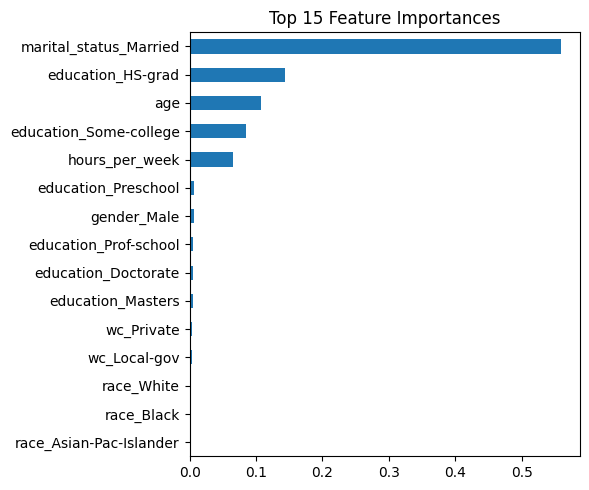

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1. Load & clean
df = pd.read_csv('04+-+decisiontreeAdultIncome.csv', skipinitialspace=True)
df.columns = [c.strip().replace(' ', '_') for c in df.columns]
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.strip()

# Target -> binary
df['IncomeClass'] = df['IncomeClass'].replace({'<=50K': 0, '>50K': 1})

# 2. Split features / target
X = df.drop('IncomeClass', axis=1)
y = df['IncomeClass']

# 3. One-hot encode categoricals
cat_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 4. Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# 5. Baseline tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

# 6. Simple pruning (tune depth / leaves)
param_grid = {
    'max_depth': [3,5,7,9,12,None],
    'min_samples_leaf': [1,3,5,10],
    'min_samples_split': [2,5,10]
}
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best = grid.best_estimator_
y_best = best.predict(X_test)
print("\nBest Params:", grid.best_params_)
print("Tuned Accuracy:", accuracy_score(y_test, y_best))

# 7. Feature importance (top 15)
importances = pd.Series(best.feature_importances_, index=X.columns)
imp_top = importances.sort_values(ascending=False).head(15)
plt.figure(figsize=(6,5))
imp_top[::-1].plot(kind='barh')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# 8. Visual (small tree only if depth limited)
if best.get_depth() <= 5:
    plt.figure(figsize=(14,6))
    plot_tree(
        best,
        feature_names=X.columns,
        class_names=['<=50K','>50K'],
        filled=True,
        proportion=True,
        max_depth=3,  # limit display depth
        fontsize=8
    )
    plt.tight_layout()
    plt.show()